In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time 
import h5py 
from scipy.ndimage.interpolation import rotate

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim


import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler

import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from keras.datasets import cifar10

import matplotlib.pyplot as plt


In [2]:
class myDropout(nn.Module):
    def __init__(self, p = 0.5):
        super(myDropout, self).__init__()
        self.p = p 
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0 - p)
        else:
            self.multiplier_ = 0
    
    def forward(self, input):
        if not self.training:
            return input
        selected = torch.Tensor(input.shape).uniform_(0, 1) > self.p
        return torch.mul(selected, input) * self.multiplier_

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(20),
    transforms.Normalize(mean = (0, 0, 0), std = (1, 1, 1)),
    transforms.Resize(256)
    ])

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images, train_labels = torch.Tensor(train_images), torch.Tensor(train_labels) 
test_images, test_labels = torch.Tensor(test_images), torch.Tensor(test_labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding = 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(p = 0.3)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        '''
        Appyling dropout at test time and running over many forward passes
        '''
        x = self.pool(self.dropout(self.conv1(x)))
        x = self.pool(self.dropout(self.conv2(x)))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout(x)))
        x = F.softmax(self.fc3(self.dropout(x)), dim = 1)

def update_target(target, original, update_rate):
        for target_param, param in zip(target.parameters(), original.parameters()):
            target_param.data.copy_((1.0 - update_rate) * target_param.data + update_rate*param.data)

In [4]:
def train(epoch, net, net_test, optimizer, log_freq = len(train_images)//64):
    running_loss = 0.0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for i, data in enumerate(train_images, 0):
        inputs, labels = train_images, train_labels
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        cross_entropy = nn.CrossEntropyLoss()
        outputs = net(inputs)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        update_target(net_test, net, 0.001)
        running_loss += loss.item()

        if (i + 1) % log_freq == 0:
            print('[Epoch: %d, Iteration: %4d] Loss: %.3f' %(epoch + 1, i + 1, running_loss/log_freq))
        return running_loss / log_freq

In [5]:
from tqdm import tqdm_notebook

lenets = [LeNet]
epoch_num = 200
test_freq = 10
losses = list()
net_scores = list()
test_scores = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
is_train = True

def main():
    for lenet in lenets:
        print(lenet.__name__)
        net = lenet()
        net_test = lenet()
        if torch.cuda.device_count() > 1:
            print("Let's use",torch.cuda.device_count(),"GPUs!")
            net = nn.DataParallel(net)
            net_test = nn.DataParallel(net_test)
        net.to(device)
        net_test.to(device)
        net_test.load_state_dict(net.state_dict())
        
        optimizer = optim.Adam(net.parameters(), lr = 5e-4, weight_decay = 0.0005, amsgrad = True)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.75)
        
        for i in tqdm_notebook(range(epoch_num)):
            scheduler.step()
            if lenet.__name__ == 'Net_DO':
                net.train()
                net_test.train()
            loss_avg = train(epoch = i, net = net, net_test = net_test, optimizer=optimizer)
            losses.append(loss_avg)
            


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def function(x):
    return 0.8 * np.power(x, 3) + 2 * np.power(x, 2) + 4 * x

n, sigma = 10000, 1
X = np.linspace(-3, 3, n)
y_real = function(X)
y_noise = (y_real + np.random.normal(0, sigma, n))

# plt.rcParams['figure.figsize'] = [8, 7]
# plt.plot(X, y_noise, '.', markersize = 1, color = 'black')
# plt.plot(X, y_real, 'r', linewidth = 3, color = 'red')
# plt.legend(['Data', 'y=x^3'], loc = 'best')
# plt.show()

X, y_noise = X.reshape(-1, 1), y_noise.reshape(-1, 1)

from sklearn.preprocessing import StandardScaler
x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_scaled = x_scaler.fit_transform(X)
y_noise_scaled = y_scaler.fit_transform(y_noise)

In [7]:
def make_sequential(in_, out_, do_rate):
    return nn.Sequential(nn.Linear(in_, out_),
                       nn.ReLU(),
                       nn.Dropout(p = do_rate))

class BaseModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim,
               hidden_L, do_rate, w_decay):
    super(BaseModel, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.do_rate = do_rate
    self.w_decay = w_decay
    self.in_layer = nn.Linear(input_dim, hidden_dim)
    
    self.layers = nn.ModuleList()
    self.layers.append(make_sequential(input_dim, hidden_dim, self.do_rate))
    self.layers.extend([make_sequential(hidden_dim, hidden_dim, self.do_rate) for _ in range(hidden_L)])
    self.layers.append(nn.Linear(hidden_dim, output_dim))


  def forward(self,x):
    for layer in self.layers:
      x = layer(x.float())
    return x.float()

In [8]:
X_scaled = torch.tensor(x_scaled, dtype = torch.float64).view(-1, 1).to(device)
Y_noise_scaled = torch.tensor(y_noise_scaled, dtype = torch.float64).view(-1, 1).to(device)

model = BaseModel(input_dim = 1,hidden_dim = 20,output_dim = 1,hidden_L = 2,
                  do_rate = 0.2, w_decay = 1e-6).to(device)
loss_fn  = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, weight_decay = model.w_decay)

In [9]:
for iter in range(10000):
    Y_pred_scaled = model(X_scaled).float()
    optimizer.zero_grad()
    loss = loss_fn(Y_pred_scaled,Y_noise_scaled.float())
    loss.backward()
    optimizer.step()
    
    if iter % 1000 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(iter, loss.item()))

Epoch: 0, Loss: 1.0236
Epoch: 1000, Loss: 0.1573
Epoch: 2000, Loss: 0.1238
Epoch: 3000, Loss: 0.1061
Epoch: 4000, Loss: 0.0967
Epoch: 5000, Loss: 0.0921
Epoch: 6000, Loss: 0.0803
Epoch: 7000, Loss: 0.0793
Epoch: 8000, Loss: 0.0722
Epoch: 9000, Loss: 0.0728


In [11]:
Y_pred =  y_scaler.inverse_transform(Y_pred_scaled.cpu().data.numpy())

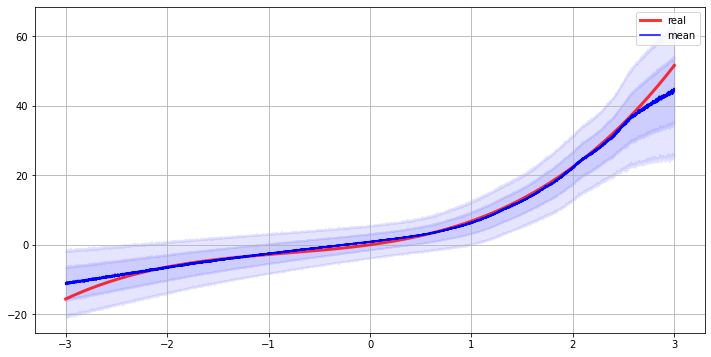

In [21]:
def uncertainity_estimate(x, model, num_samples, l2):
    # Sample T set of vectors {z(1), z(2), ..., z(L)}^(T, t = 1)
    scaled_outputs = np.hstack([model(x).cpu().detach().numpy() for _ in range(num_samples)]) 
    outputs = y_scaler.inverse_transform(scaled_outputs)

    # Estimate mean and variance
    y_mean = outputs.mean(axis = 1)
    y_variance = outputs.var(axis = 1)
    tau = l2 * (1. - model.do_rate) / (2. * n * model.w_decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)

    return y_mean, y_std

y_mean, y_std = uncertainity_estimate(X_scaled, model, 1000, 0.01)

plt.figure(figsize=(12,6))
plt.plot(X, y_real, ls="-", linewidth = 3, color = 'red', alpha = 0.8, label = "real")
plt.plot(X, y_mean, ls = "-", color = "blue", label = "mean")
for a in range(1, 3):
    plt.fill_between(X.reshape(-1,),
        y_mean - y_std *a,
        y_mean + y_std *a,
        color = "b",
        alpha=0.1)
plt.legend()
plt.grid()